In [1]:
import numpy as np
import pandas as pd
import cv2
import re
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras import layers, models
class_csv = pd.read_csv('/kaggle/input/camvid/CamVid/class_dict.csv')
class_csv.head()

2026-01-04 06:18:27.614011: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767507507.787233      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767507507.836180      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767507508.297824      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767507508.297858      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767507508.297862      55 computation_placer.cc:177] computation placer alr

,name,r,g,b
0,Animal,64,128,64
1,Archway,192,0,128
2,Bicyclist,0,128,192
3,Bridge,0,128,64
4,Building,128,0,0


In [2]:
len(class_csv)

32

## All Labels 

In [3]:
class_csv['name'].unique()

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype=object)

In [6]:
framObjTrain = {'img' : [],
           'mask' : []
          }

framObjValidation = {'img' : [],
           'mask' : []
          }

def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 128):
    imgNames = os.listdir(imgPath)
    maskNames = []
    
    ## generating mask names
    for mem in imgNames:
        maskNames.append(re.sub('\.png', '_L.png', mem))
    
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    for i in range (len(imgNames)):
        img = plt.imread(imgAddr + imgNames[i])
        mask = plt.imread(maskAddr + maskNames[i])
        
        img = cv2.resize(img, (shape, shape)) 
        mask = cv2.resize(mask, (shape, shape))
        
        frameObj['img'].append(img)
        frameObj['mask'].append(mask)
        
    return frameObj

<>:15: SyntaxWarning: invalid escape sequence '\.'
<>:15: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipykernel_55/3456404485.py:15: SyntaxWarning: invalid escape sequence '\.'
  maskNames.append(re.sub('\.png', '_L.png', mem))


In [7]:
framObjTrain = LoadData( framObjTrain, imgPath = '/kaggle/input/camvid/CamVid/train', maskPath = '/kaggle/input/camvid/CamVid/train_labels'
         , shape = 128)
framObjValidation  = LoadData( framObjValidation, imgPath = '/kaggle/input/camvid/CamVid/val', maskPath = '/kaggle/input/camvid/CamVid/val_labels'
         , shape = 128)

## Training Images and its Masks (Ground truth)

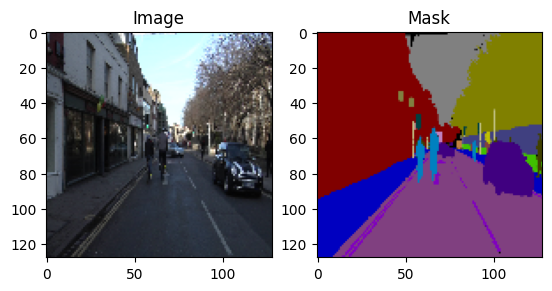

In [8]:
plt.subplot(1,2,1)
plt.title("Image")
plt.imshow(framObjTrain['img'][1])
plt.subplot(1,2,2)
plt.title("Mask")
plt.imshow(framObjTrain['mask'][1])
plt.show()

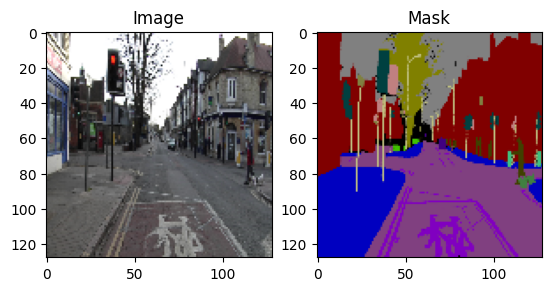

In [9]:
plt.subplot(1,2,1)
plt.title("Image")
plt.imshow(framObjTrain['img'][2])
plt.subplot(1,2,2)
plt.title("Mask")
plt.imshow(framObjTrain['mask'][2])
plt.show()

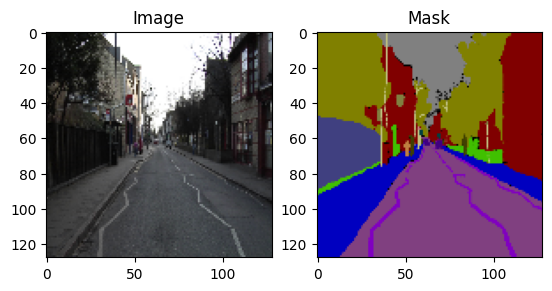

In [10]:
plt.subplot(1,2,1)
plt.title("Image")
plt.imshow(framObjTrain['img'][3])
plt.subplot(1,2,2)
plt.title("Mask")
plt.imshow(framObjTrain['mask'][3])
plt.show()

## Building and Training the model


In [12]:
def conv_block (input_tensor,num_filters):
    x = layers.Conv2D(num_filters,3,padding="same")(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(num_filters,3,padding="same")(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    return x

def encoder_block(input_tensor,num_filters):
    x = conv_block(input_tensor,num_filters)
    p = layers.MaxPooling2D((2,2))(x)
    return x, p

def decoder_block(input_tensor,skip_features,num_filters):
    x = layers.Conv2DTranspose(num_filters,(2,2),strides=2,padding="same")(input_tensor)
    x = layers.Concatenate()([x,skip_features])
    x = conv_block(x,num_filters)
    return x 

In [13]:
def Build_model(input_tensor):
    s1,p1 = encoder_block(input_tensor,16)
    s2,p2 = encoder_block(p1,32)
    s3,p3 = encoder_block(p2,64)
    s4,p4 = encoder_block(p3,128)

    b1 = conv_block(p4,256)

    d1 = decoder_block(b1,s4,128)
    d2 = decoder_block(d1,s3,64)
    d3 = decoder_block(d2,s2,32)
    d4 = decoder_block(d3,s1,16)

    outputs = layers.Conv2D(3,(1,1),padding = "same",activation = 'sigmoid')(d4)
    model = models.Model(inputs = input_tensor,outputs = outputs, name="U-net")
    return model

input_tensor = layers.Input((128, 128, 3))
myModel = Build_model(input_tensor)
myModel.compile(optimizer="adam",loss="binary_crossentropy",metrics=['accuracy'])    

I0000 00:00:1767507609.466554      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1767507609.470517      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [14]:
myModel.summary()

Model: "U-net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ re_lu_3[0][0]     │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_5 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ re_lu_5[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_7 (ReLU)      │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 128) │          0 │ re_lu_7[0][0]   

 Total params: 961,843 (3.67 MB)

 Trainable params: 960,371 (3.66 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [15]:
retVal = myModel.fit(np.array(framObjTrain['img']), np.array(framObjTrain['mask']), epochs = 100, verbose = 1)

Epoch 1/100


I0000 00:00:1767507636.072914     134 service.cc:152] XLA service 0x7ef31d24d450 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767507636.072952     134 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1767507636.072956     134 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1767507637.280091     134 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-01-04 06:20:40.565324: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-04 06:20:40.843696: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-04 06:20:41.129983: E external/local_xl

 2/12 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6548 - loss: 0.6838 

I0000 00:00:1767507648.270424     134 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6276 - loss: 0.6612

2026-01-04 06:20:51.424170: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-04 06:20:51.694600: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-04 06:20:51.944144: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-04 06:20:52.087262: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-04 06:20:52.874012: E external/local_xla/xla/stream_

12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 876ms/step - accuracy: 0.6233 - loss: 0.6582
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5076 - loss: 0.5992
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.4989 - loss: 0.5792
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.4807 - loss: 0.5644
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.4705 - loss: 0.5582
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.4825 - loss: 0.5545
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5178 - loss: 0.5482
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5348 - loss: 0.5384
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5809 - loss: 0.5340
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.6079 - loss: 0.5329
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.6164 - loss: 0.5305
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accurac

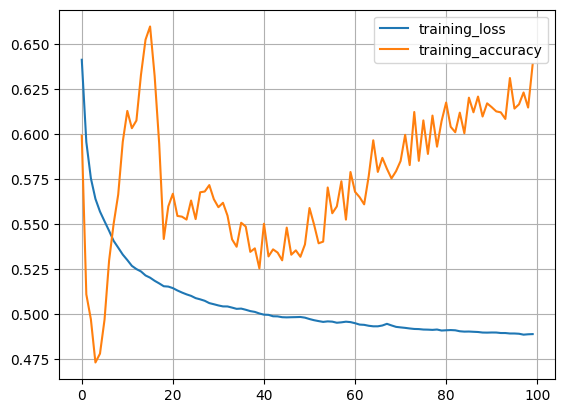

In [16]:
plt.plot(retVal.history['loss'],label = 'training_loss')
plt.plot(retVal.history['accuracy'],label = 'training_accuracy')
plt.legend()
plt.grid(True)

In [23]:
def predict16 (valMap, model, shape = 256):
   
    img = valMap['img']
    mask = valMap['mask']
    mask = mask[0:16]
    
    imgProc = img [0:16]
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
    for i in range(len(predictions)):
        predictions[i] = cv2.merge((predictions[i,:,:,0],predictions[i,:,:,1],predictions[i,:,:,2]))
    
    return predictions, imgProc, mask
    

    
    
def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(7,7))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('image')
    
    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted Mask')
    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('actual Mask')

   

In [21]:
sixteenPrediction, actuals, masks = predict16(framObjValidation, myModel)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


## Predictions

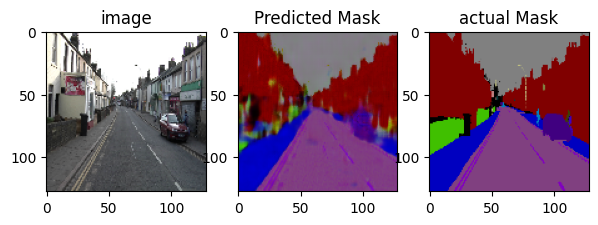

In [24]:
Plotter(actuals[1], sixteenPrediction[1], masks[1])